In [2]:
import comet_ml
import numpy as np
import torch
import os
from torchvision import transforms
from pytorch_lightning.loggers import CometLogger

torch.cuda.empty_cache()

In [3]:
comet_logger = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    project_name="image_inpainting",
)

CometLogger will be initialized in online mode


In [4]:
import pandas as pd
from inpainting.InpaintingDataset import *
from torch.utils.data import DataLoader

df = pd.read_parquet('local_wikiart.parquet', columns=['title', 'artist', 'date', 'genre', 'style', 'image']).head(5000)

total_len = len(df)
train_len = int(0.8 * total_len)
val_len = int(0.5 * (total_len - train_len))
train_df = df[:train_len].copy(deep=True)
val_df = df[train_len:train_len+val_len].copy(deep=True)
test_df = df[train_len+val_len:].copy(deep=True)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = InpaintingDataset(df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=10)
val_dataset = InpaintingDataset(df, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=10)
test_dataset = InpaintingDataset(df, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=10)

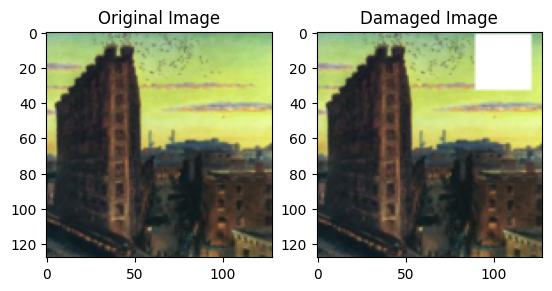

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

damaged_img, original_img = train_dataset[0]
mask = damaged_img[3, :, :]
damaged_img = damaged_img[:3, :, :]

# mask = mask.unsqueeze(0)
# mask_3d = mask.expand_as(damaged_img)
# final_img = mask_3d * damaged_img + (1 - mask_3d) * original_img

damaged_img = damaged_img.permute(1, 2, 0)
original_img = original_img.permute(1, 2, 0)
# final_img = final_img.permute(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Original Image")
ax1.imshow(original_img)
ax2.set_title("Damaged Image")
ax2.imshow(damaged_img)
plt.show()

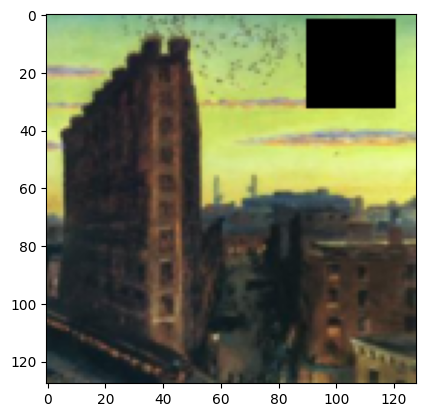

In [14]:
hole = original_img
hole[mask == 0] = 0
plt.imshow(hole)
plt.show()

In [15]:
from inpainting.InpaintingMOGAN import InpaintingMIGAN
from inpainting.InpaintingGAN import *

generator = Generator()
critic = Critique()
model = GANInpainting(generator, critic)
# model = InpaintingMIGAN()

/home/aneta/Documents/UNN/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'generator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator'])`.
/home/aneta/Documents/UNN/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'critique' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critique'])`.


In [16]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = Trainer(
        logger=comet_logger,
        # fast_dev_run=True,
        max_epochs=50,
        accelerator="gpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(monitor="generator_loss", save_top_k=1, mode="min", filename="gan-inpainting-{epoch:02d}-{generator_loss:.2f}"),
            EarlyStopping('val_loss', patience=10)
        ]
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
torch.set_float32_matmul_precision('medium')

In [ ]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


In [ ]:
trainer.test(model, dataloaders=test_dataloader)

In [ ]:
damaged_img, original_img = train_dataset[0]
damaged_img = damaged_img.unsqueeze(0)

model.eval()
reconstructed = model(damaged_img)
reconstructed_img = reconstructed.detach().squeeze()
plt.imshow(reconstructed_img.permute(1, 2, 0))
plt.show()